In [2]:
!pip install pandas numpy scikit-learn matplotlib tensorflow imbalanced-learn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


# Essential Libraries for Neural Network

This libraries is important for general Machine Learning like scikit-learning, or pandas, for the Neural Network, the tensorflow model is necessary for us to create ANN (Artificial Neural Network)

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn for preprocessing and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    classification_report, precision_recall_curve, ConfusionMatrixDisplay
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer

# Imbalanced-learn for handling imbalanced datasets
from imblearn.over_sampling import SMOTE

# TensorFlow and Keras for building and training the ANN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers, optimizers

import keras_tuner as kt # For Hyperparameter Tuning for model
from IPython.display import display  # For better DataFrame display in Jupyter Notebooks

#Global Seed
SEED = 0

# Data Import and Inspection

Here, we need to import the data that we want to train and inspect to see what we going to **deal** with

In [4]:
df = pd.read_csv("SR386_labels.csv")
print(f"Data Loaded Successfully, Initial Data Shape: {df.shape}")
df.head()

Data Loaded Successfully, Initial Data Shape: (427, 30)


,case_id,died_within_5_years,days_till_death,crc_primary_cause_of_death,age_at_diagnosis,sex,site_of_tumour,site_of_tumour_grouping,kras_ex_2,kras_ex_3,...,pN,pM,tumour_type,differentiation,peri_surface_involved,distance_to_peritoneum_macroscopic_measurement,em_lvi,em_lvi_notes,pre-op_radio,pre-op_chemo
0,1,1.0,711,NaN,91,F,lower rectum,rectum,M (G12D),WT,...,NX,MX,NaN,NaN,NaN,NaN,NaN,Intramural venous,NaN,NaN
1,3,1.0,650,NaN,82,M,sigmoid,sigmoid colon,M (G12S),WT,...,N0,NaN,A/C,Mod,NaN,1mm,N,NaN,-,-
2,4,NaN,NaN,NaN,43,M,rectum,rectum,WT,WT,...,N0,Mx,A/C,Mod,N,Not assessed,N,NaN,-,-
3,6,0.0,Alive,NaN,58,F,sigmoid,sigmoid colon,WT,WT,...,N0,MX,A/C,Mod,N,4mm,N,Intramural venous,-,-
4,7,1.0,1884,NaN,64,M,rectosigmoid,rectum,WT,WT,...,N0,NaN,A/C,Mod,Y,NaN,Y,Venous,-,-


Now we can see that we have 427 data with 30 features, one being our label, our case id, and the rest is model's attribute

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 30 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   case_id                                         427 non-null    int64  
 1   died_within_5_years                             425 non-null    float64
 2   days_till_death                                 425 non-null    object 
 3   crc_primary_cause_of_death                      95 non-null     float64
 4   age_at_diagnosis                                427 non-null    int64  
 5   sex                                             427 non-null    object 
 6   site_of_tumour                                  425 non-null    object 
 7   site_of_tumour_grouping                         425 non-null    object 
 8   kras_ex_2                                       427 non-null    object 
 9   kras_ex_3                                  

We now print out the information about the column itself and we can tell that theres missing data within the dataset as well

In [6]:
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]  

We make sure that all of the column is standarize with spaces changes to underscore.

In [7]:
target_column = 'died_within_5_years'
if target_column in df.columns:
    print(f"Target column '{target_column}' found in the dataset.")
else:
    raise ValueError(f"Target column '{target_column}' not found in the dataset.")

Target column 'died_within_5_years' found in the dataset.


Now we select our target column within dataframe.

In [8]:
n_before = df.shape[0]
df = df.dropna(subset=target_column).copy() # Copy to replace the new dataframe without missing target values
n_after = df.shape[0]
print(f"Number of rows after dropping missing values: {n_after}")

Number of rows after dropping missing values: 425


We then use that target column to drop our data since we can't impute the target and it can causes issues with our data heavily.

In [9]:
df[target_column] = df[target_column].astype(int)
print(f"\nTarget Distribution (After Cleaning):\n{df[target_column].value_counts()}")


Target Distribution (After Cleaning):
died_within_5_years
0    264
1    161
Name: count, dtype: int64


Handles boolean data or numeric to just 0/1

In [10]:
target_col = ['died_within_5_years']
vc = df[target_col].value_counts(dropna=False)
print(vc)
print('\nProportions:')
print(df[target_col].value_counts(normalize=True))

died_within_5_years
0                      264
1                      161
Name: count, dtype: int64

Proportions:
died_within_5_years
0                      0.621176
1                      0.378824
Name: proportion, dtype: float64


We display label's count within the data and shows that we have about 62/38 split between the died and not died patients.

# Feature Distribution & Data Exploration (EDA)

This to see the general information about the features/attributes we are handling within this data

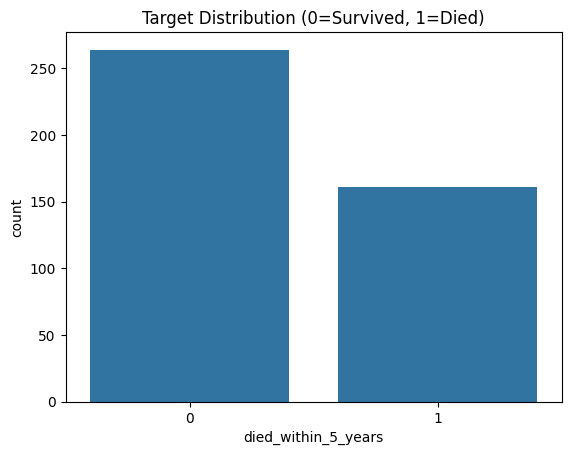

In [11]:
sns.countplot(x=df[target_col[0]])
plt.title('Target Distribution (0=Survived, 1=Died)')
plt.show()

Here's the general visualization from the previous information. There's 264 patients that survived and 161 patients who didn't survived

In [12]:
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_features_visual = [col for col in numeric_features if col != target_column]

In [13]:
categorial_features_vis = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

Here we separate between the numeric data and the categorial feature

Numeric Features: ['case_id', 'crc_primary_cause_of_death', 'age_at_diagnosis', 'mmr_loss_binary']


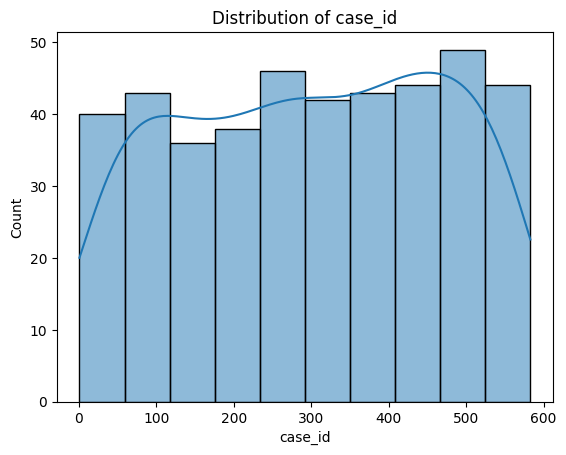

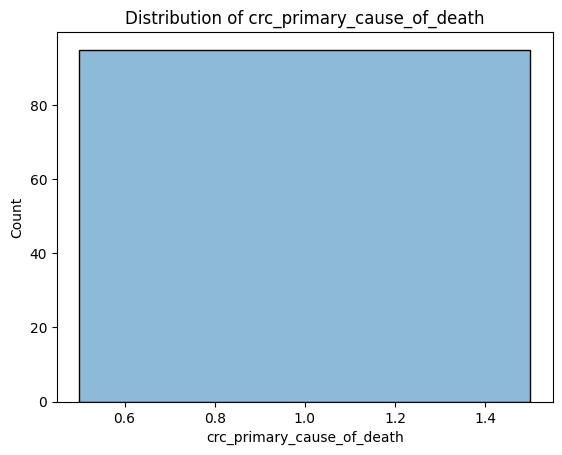

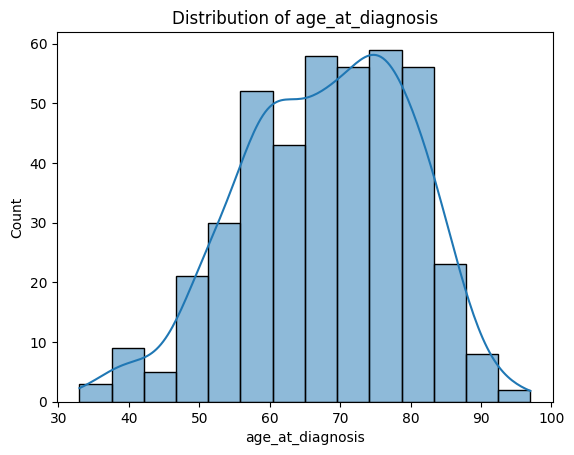

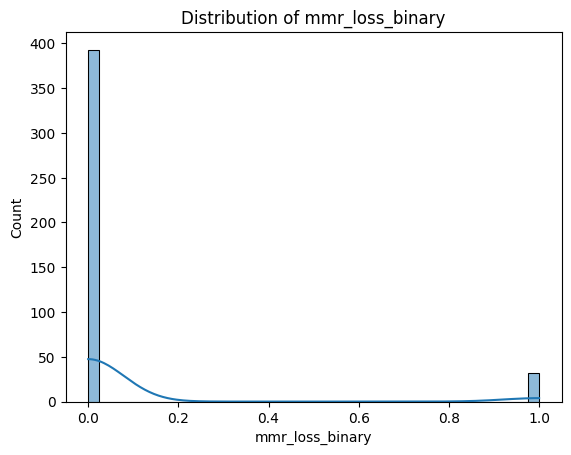

In [14]:
print("Numeric Features:", numeric_features_visual)
for col in numeric_features_visual:
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

Categorial Features: ['days_till_death', 'sex', 'site_of_tumour', 'site_of_tumour_grouping', 'kras_ex_2', 'kras_ex_3', 'kras_codon_117', 'nras_ex_2', 'nras_ex_3', 'braf_mutant_status', 'mmr_ihc', 'primary_metastatic', 'stage', 'stage_subgroup', 'pt', 'pn', 'pm', 'tumour_type', 'differentiation', 'peri_surface_involved', 'distance_to_peritoneum_macroscopic_measurement', 'em_lvi', 'em_lvi_notes', 'pre-op_radio', 'pre-op_chemo']


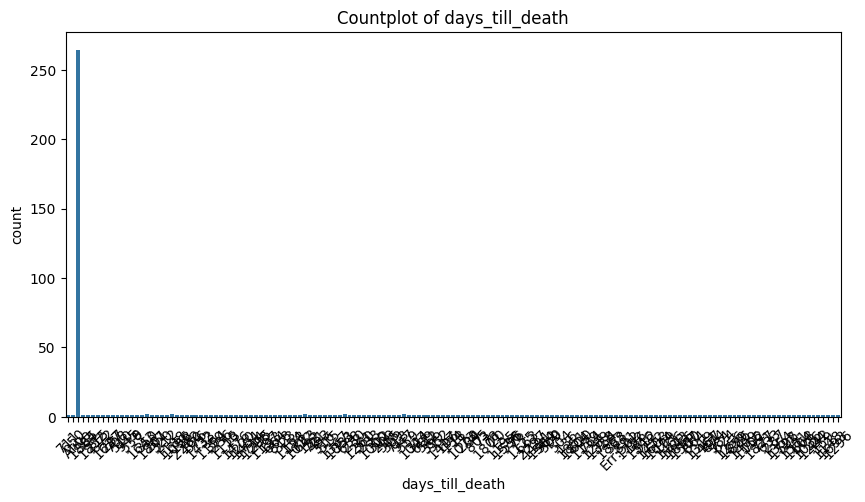

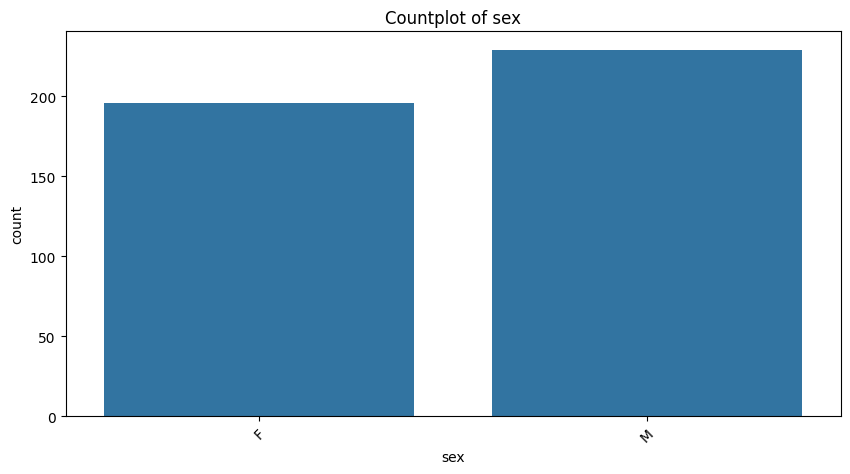

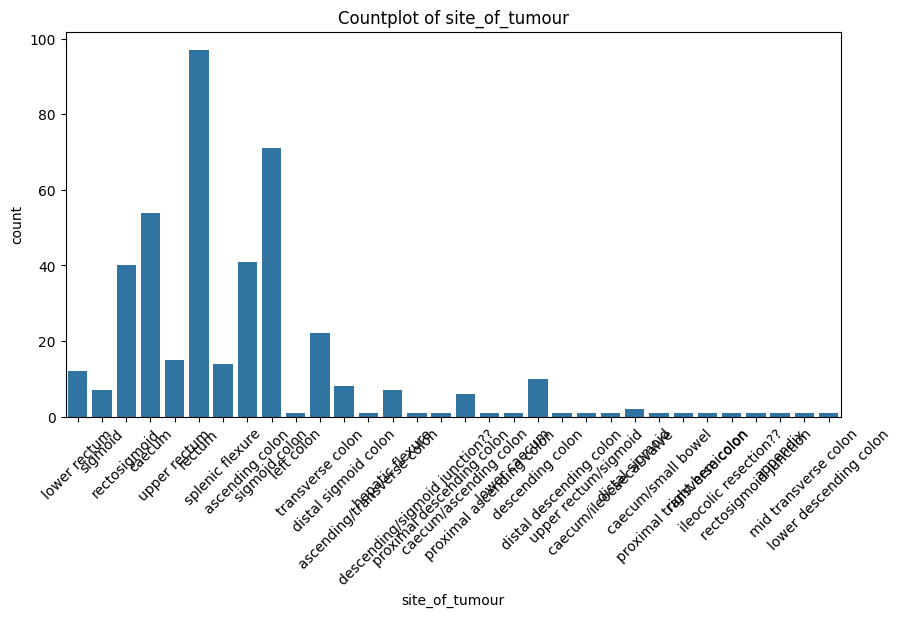

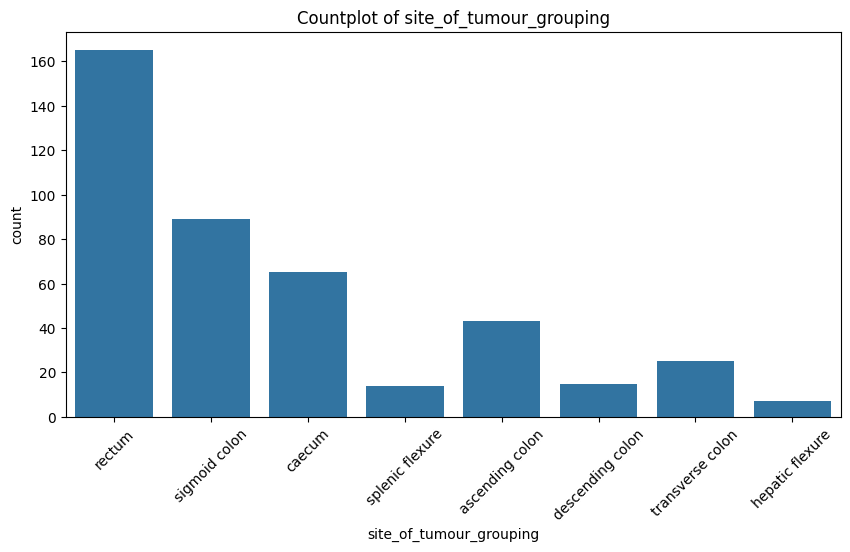

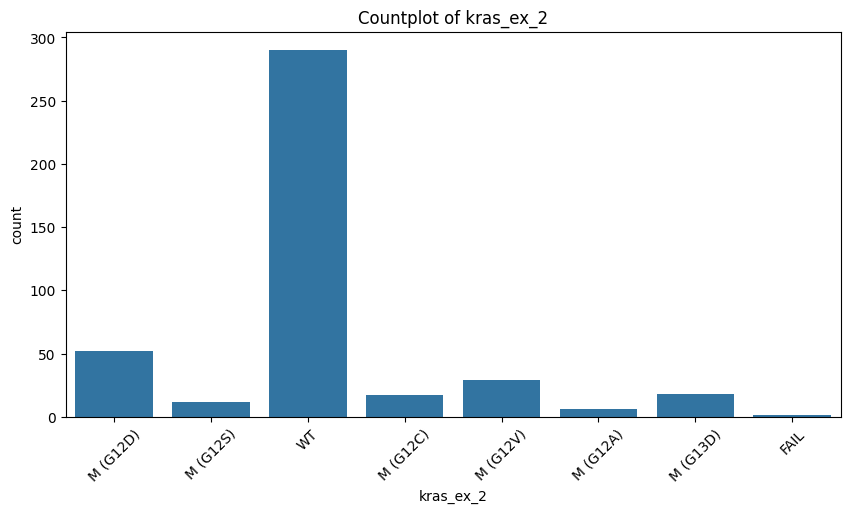

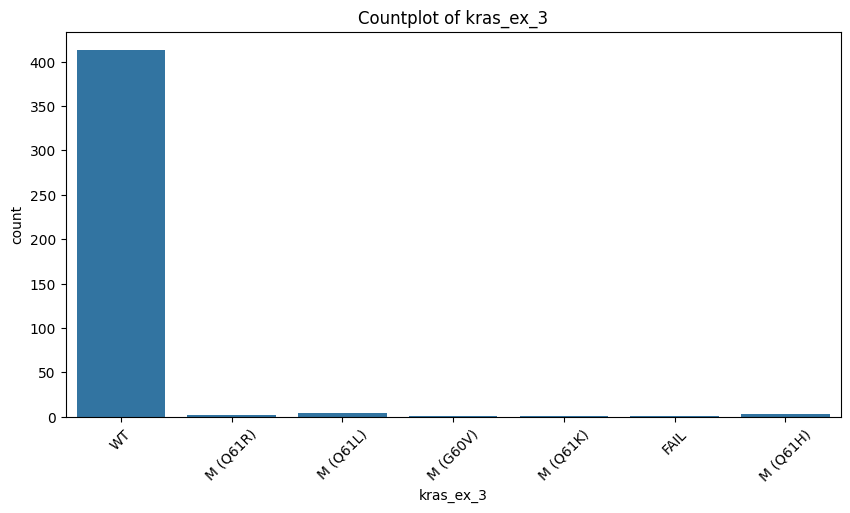

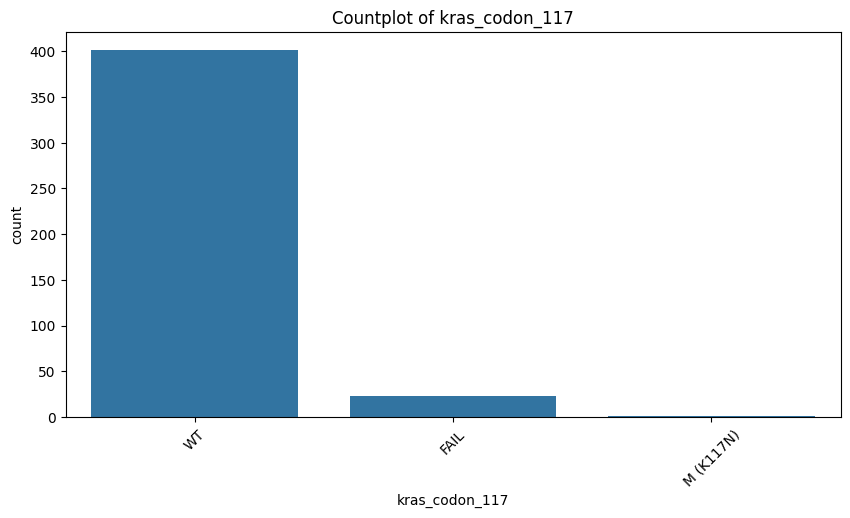

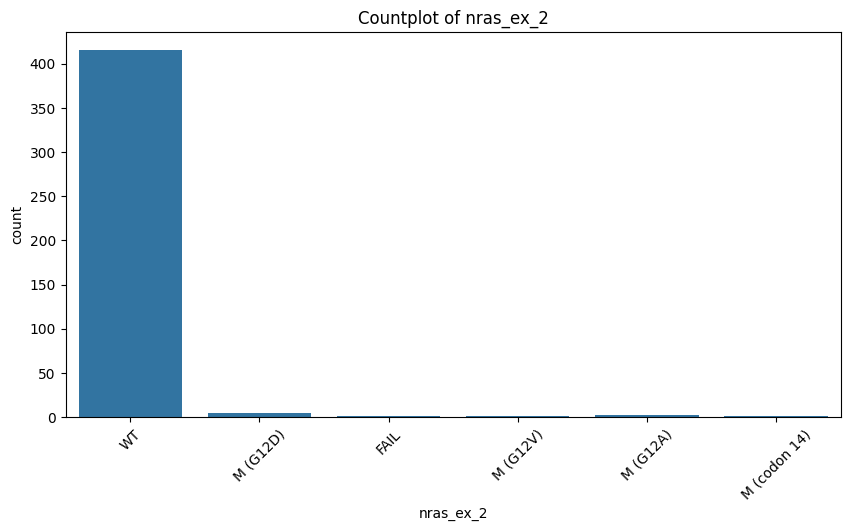

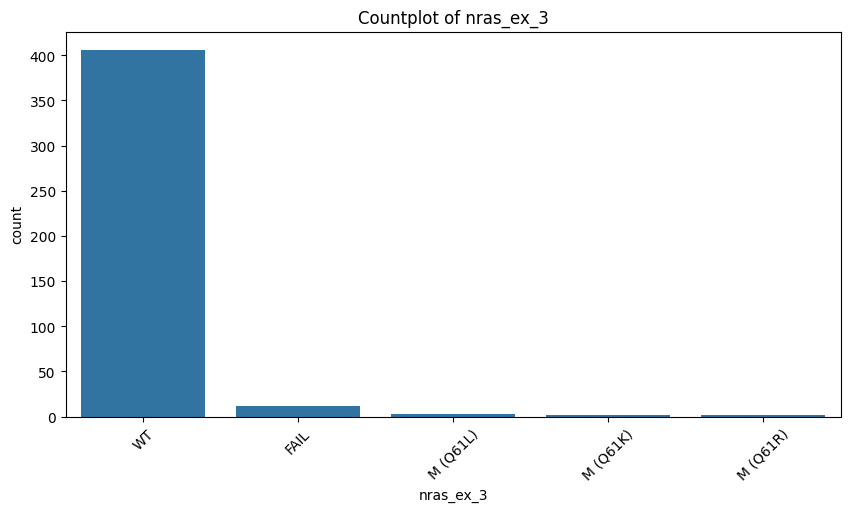

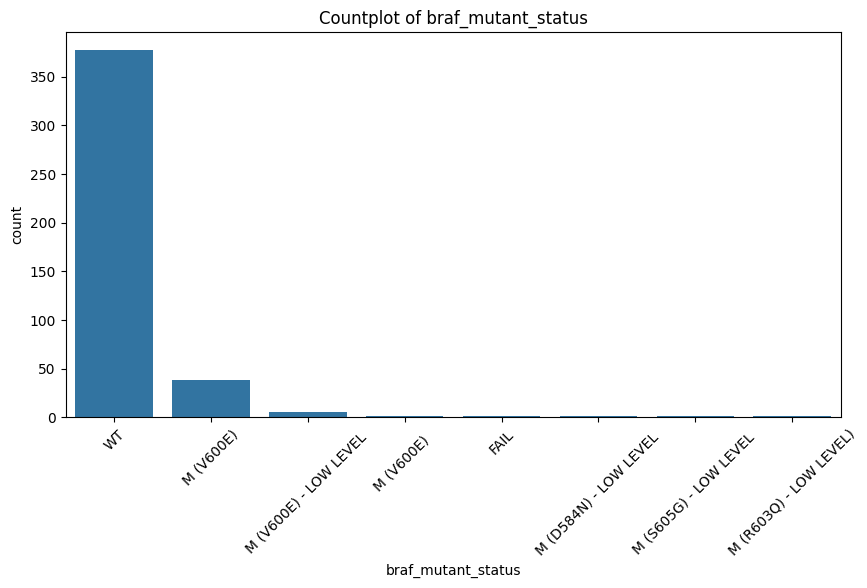

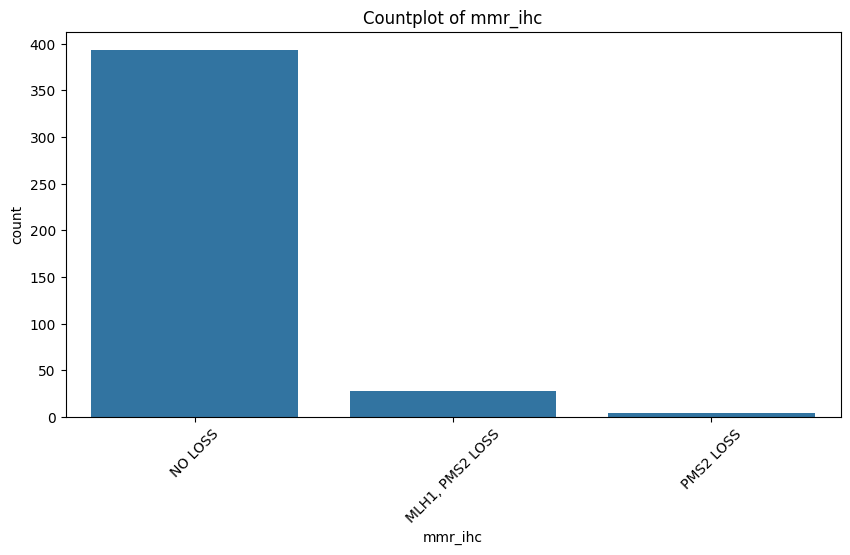

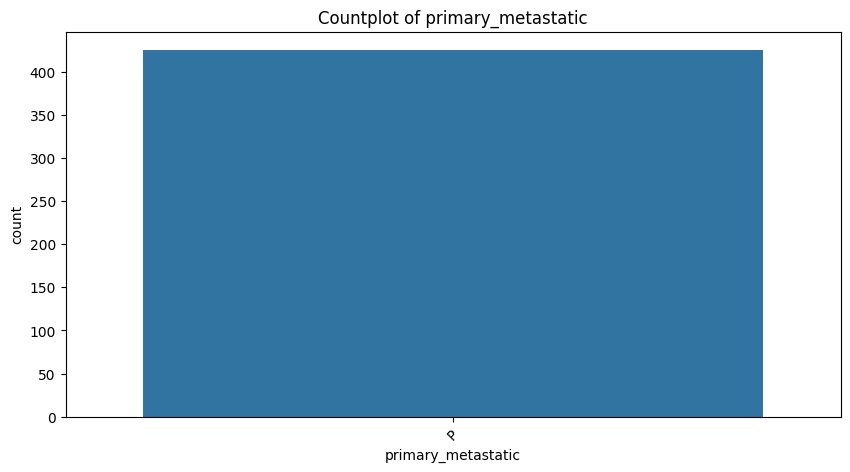

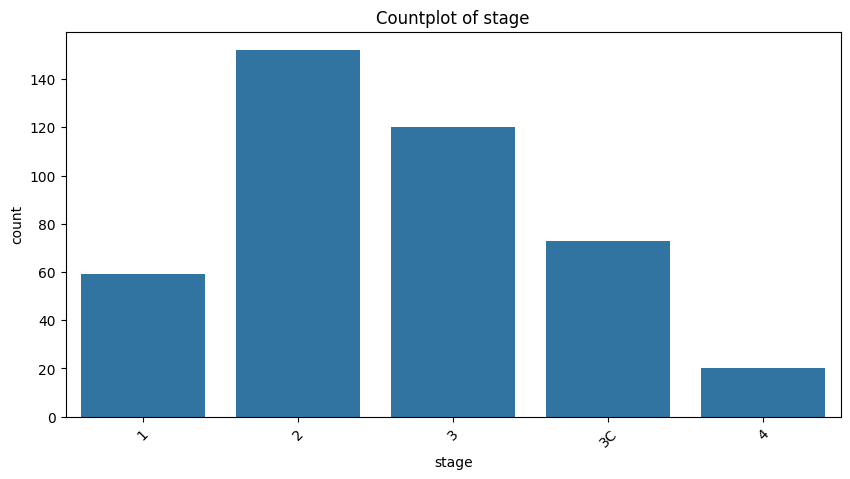

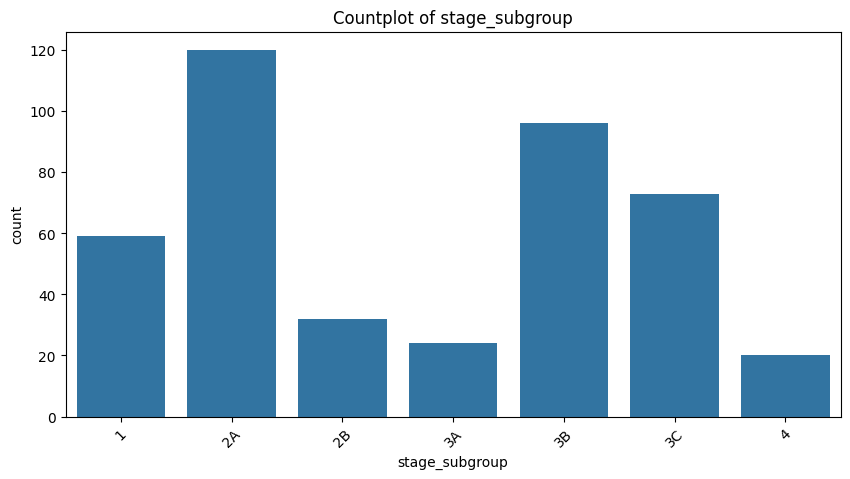

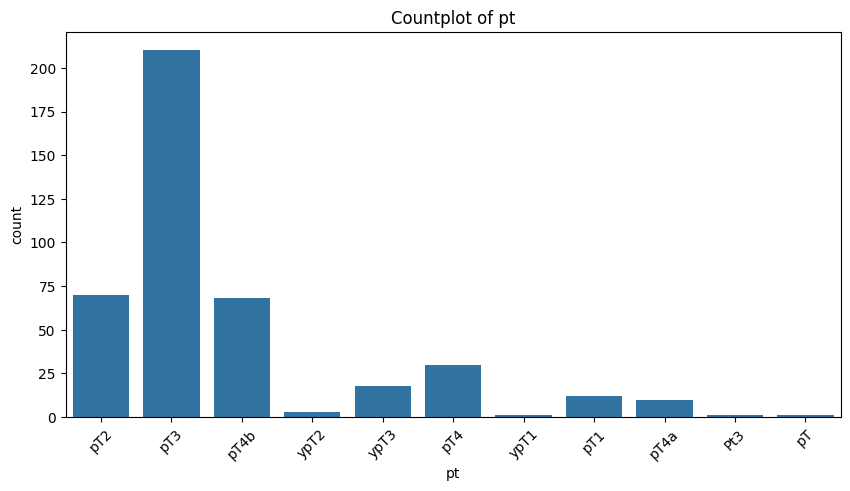

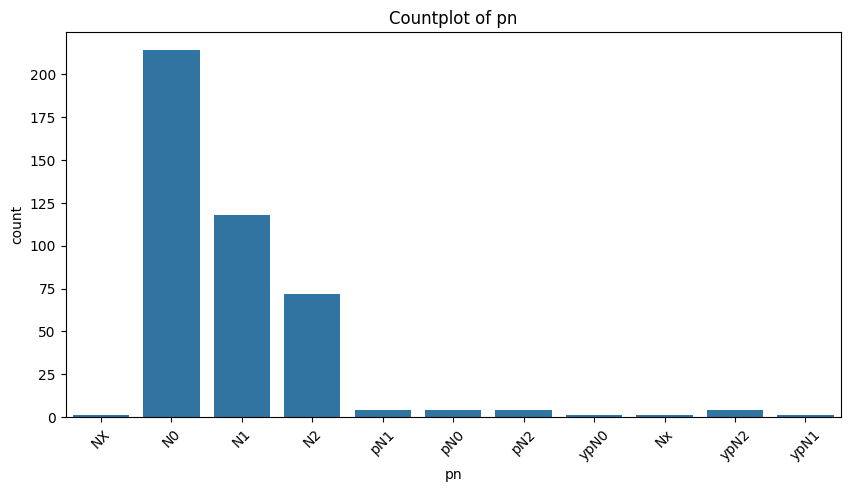

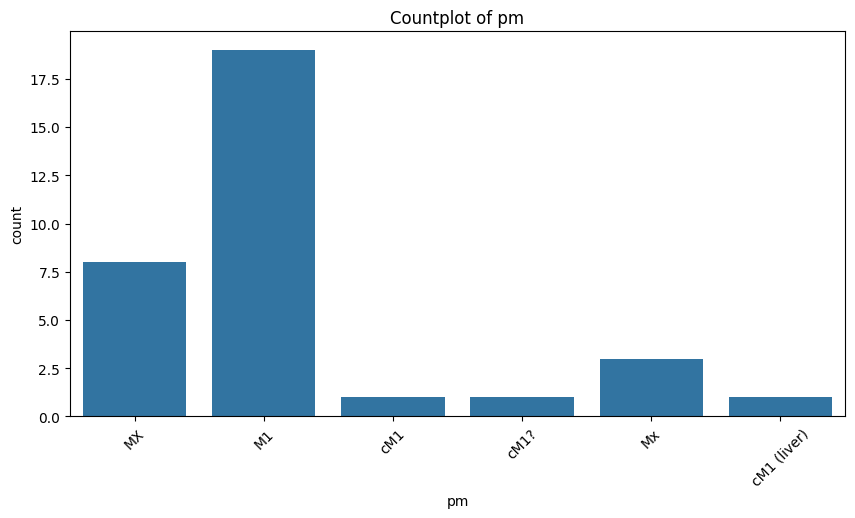

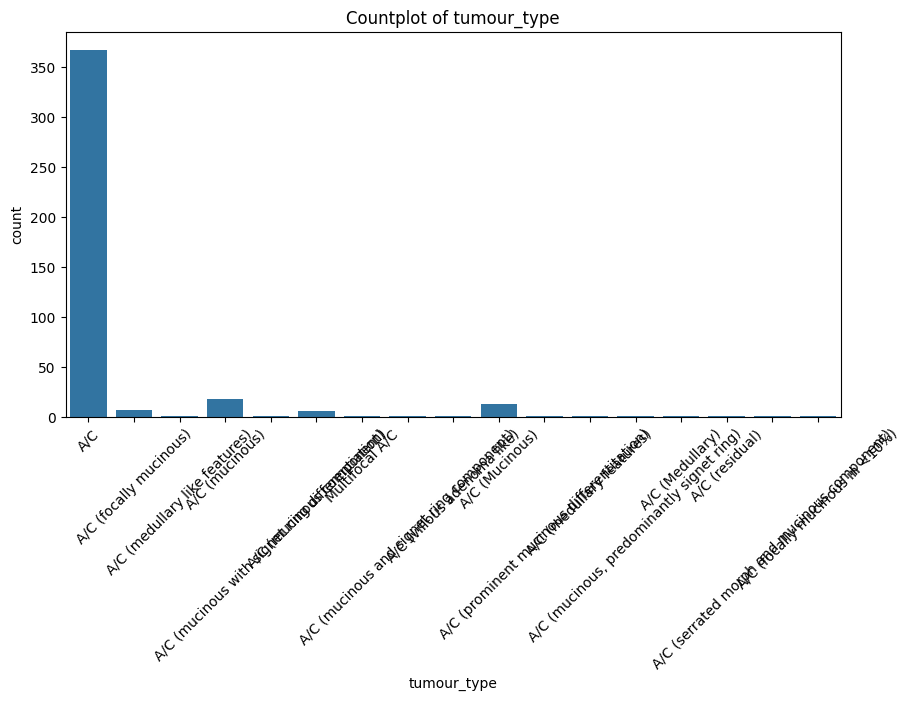

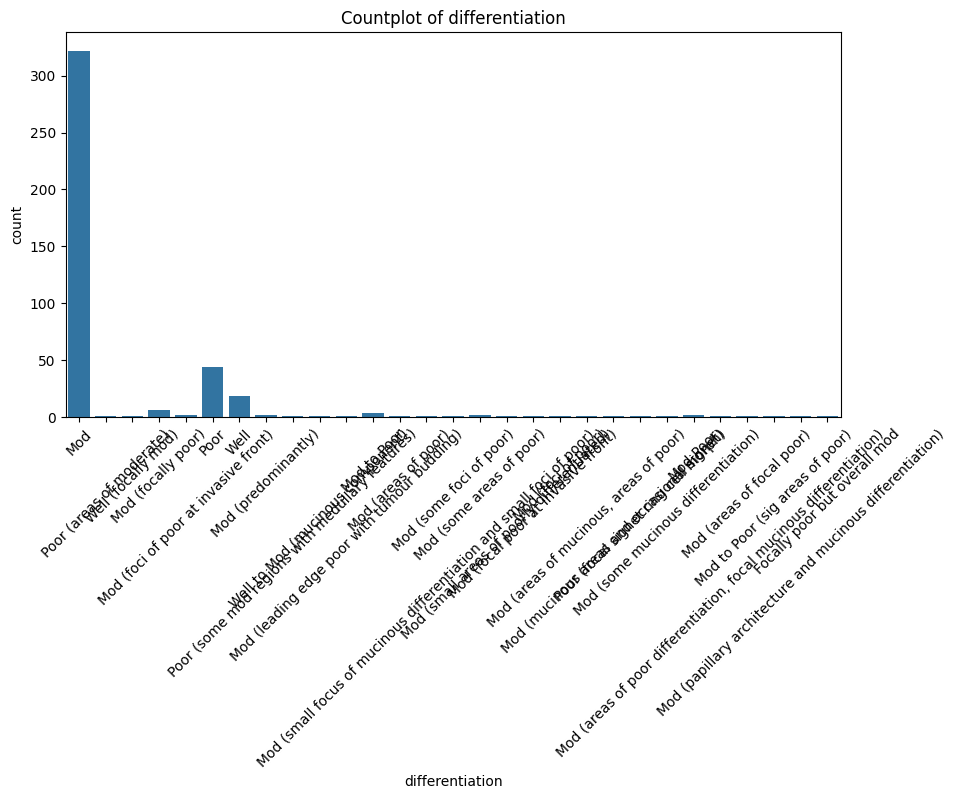

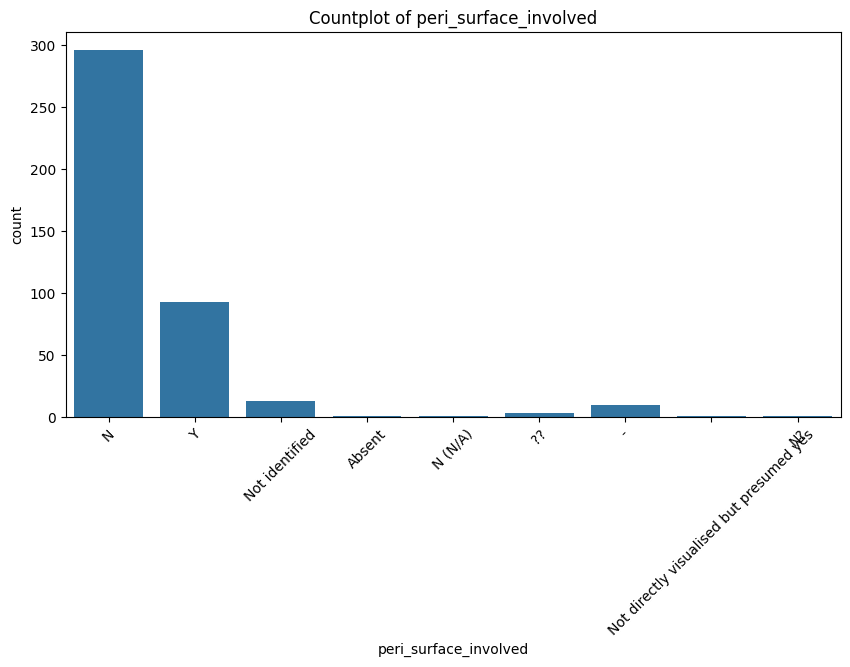

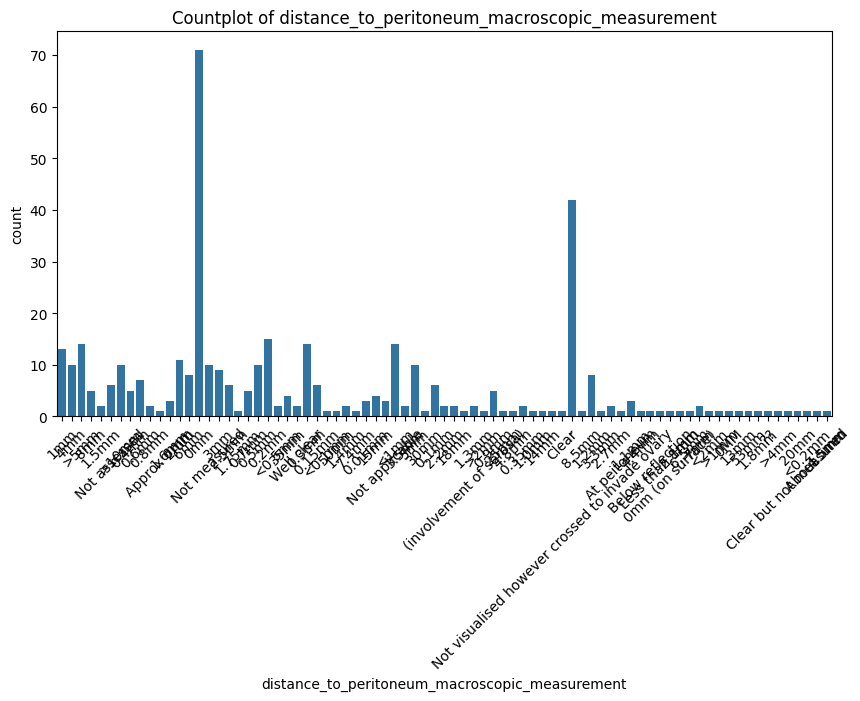

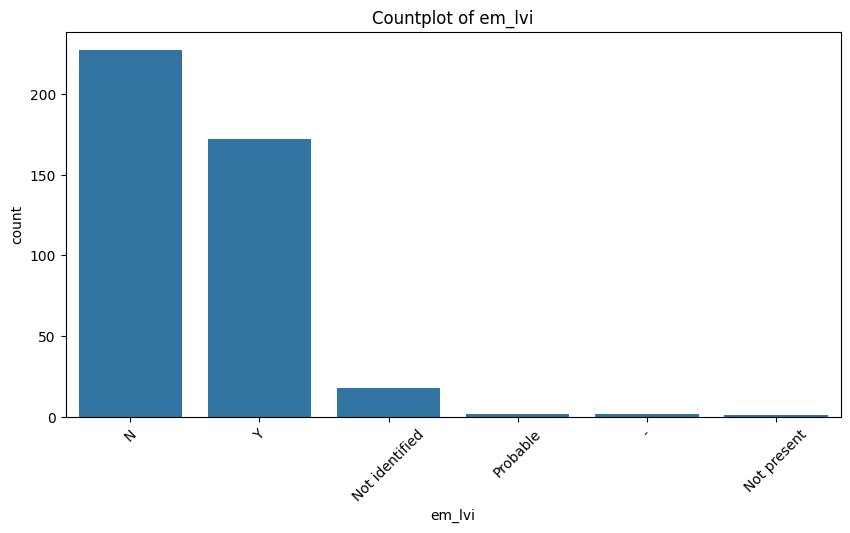

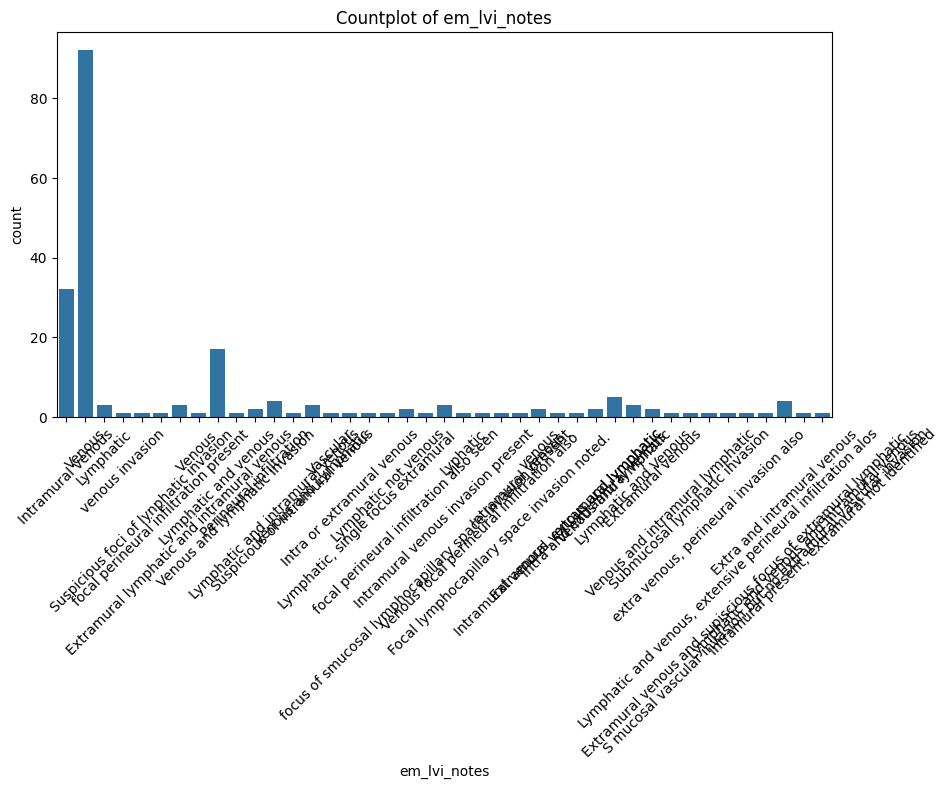

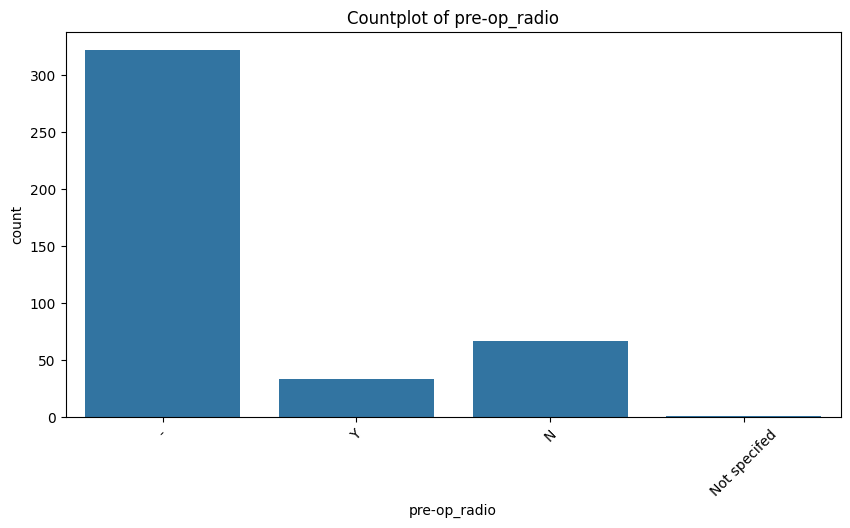

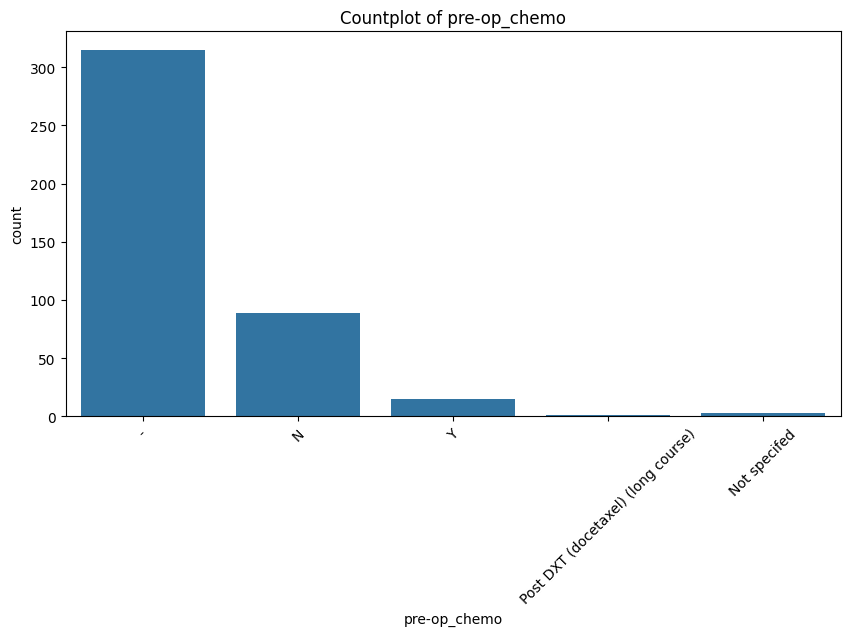

In [15]:
print("Categorial Features:", categorial_features_vis)
for col in categorial_features_vis:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=col)
    plt.title(f'Countplot of {col}')
    plt.xticks(rotation=45)
    plt.show()

Here we can generally see how our data look generally, we will use these knowledge to handle missing data, clean and preprocess before model training.

# Data Cleaning and Preprocessing

Our data is from real world, obiviously its not always going to perfectly filled with actual data, there will be missing values here and there. This section we will handle all of the data that is missing, preventing leakages, or irrevelent data 

In [16]:
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_data, 'Percentage': missing_percentage})


In [17]:
display(missing_df.head())

,Missing Values,Percentage
pm,392,92.235294
crc_primary_cause_of_death,330,77.647059
em_lvi_notes,221,52.000000
distance_to_peritoneum_macroscopic_measurement,25,5.882353
peri_surface_involved,6,1.411765


Here we display top 5 null values within the data, and we can tell that there's couple data that missing majority of the data doesn't contain such features. 

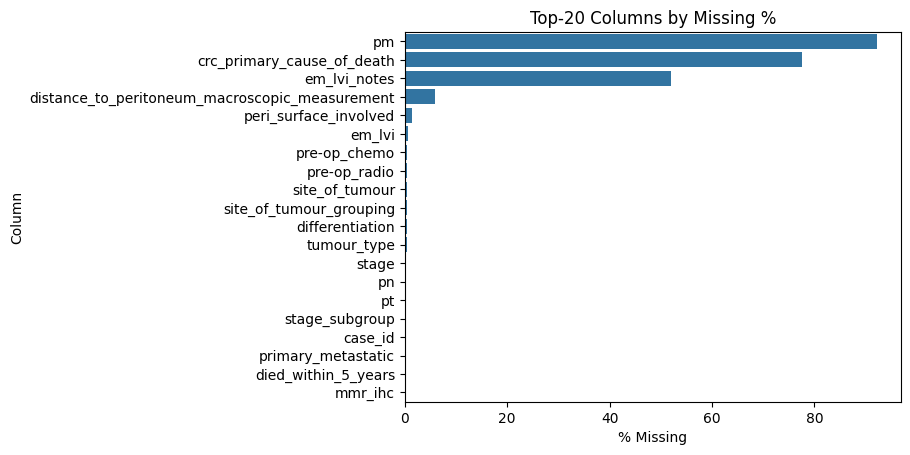

In [18]:
sns.barplot(x=missing_percentage.head(20), y=missing_percentage.head(20).index, orient='h')
plt.title('Top-20 Columns by Missing %')
plt.xlabel('% Missing')
plt.ylabel('Column')
plt.show()

This is for visualization purposes

In [19]:
missing_thre = 50.0
cols_to_drop = missing_df[missing_df['Percentage'] > missing_thre].index.tolist()
print(f"Dropping columns with more than {missing_thre}% missing values: {cols_to_drop}")
df = df.drop(columns=cols_to_drop)
print(f"Data shape after dropping columns: {df.shape}")

Dropping columns with more than 50.0% missing values: ['pm', 'crc_primary_cause_of_death', 'em_lvi_notes']
Data shape after dropping columns: (425, 27)


Here we drop the any columns with missing data, this case we drop 3 data from the list.

In [20]:
id_columns = ['case_id'] # irrelevant info as it is just an identifier
leakage_columns = ['days_till_death'] # Columns that leak target information

Next we drop the **case_id** for irrevelent data and the **days_till_death** due to leakage data

In [21]:
cols_to_drop = id_columns + leakage_columns
df = df.drop(columns=cols_to_drop)
print(df.head())
print(f"Data shape after dropping ID and leakage columns: {df.shape}")

   died_within_5_years  age_at_diagnosis sex site_of_tumour  \
0                    1                91   F   lower rectum   
1                    1                82   M        sigmoid   
3                    0                58   F        sigmoid   
4                    1                64   M   rectosigmoid   
5                    0                79   F         caecum   

  site_of_tumour_grouping kras_ex_2 kras_ex_3 kras_codon_117 nras_ex_2  \
0                  rectum  M (G12D)        WT             WT        WT   
1           sigmoid colon  M (G12S)        WT             WT        WT   
3           sigmoid colon        WT        WT             WT        WT   
4                  rectum        WT        WT             WT        WT   
5                  caecum  M (G12C)        WT           FAIL        WT   

  nras_ex_3  ... stage_subgroup    pt  pn tumour_type differentiation  \
0        WT  ...              1   pT2  NX         NaN             NaN   
1        WT  ...              

Then we drop both of the information from the dataframe

In [22]:
candidate_cols = [c for c in df.columns if c not in cols_to_drop]
numeric_cols = df[candidate_cols].select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in candidate_cols if c not in numeric_cols]
feature_cols = numeric_cols + categorical_cols

In [23]:
# Separate numeric and categorical columns
numeric_cols_with_missing = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols_with_missing = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Impute numeric columns with median
numeric_imputer = SimpleImputer(strategy='median')
df[numeric_cols_with_missing] = numeric_imputer.fit_transform(df[numeric_cols_with_missing])

# Impute categorical columns with mode
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols_with_missing] = categorical_imputer.fit_transform(df[categorical_cols_with_missing])

print("Missing values after imputation:")
print(df.isnull().sum().sum())
print(f"\nDataFrame shape after imputation: {df.shape}")

Missing values after imputation:
0

DataFrame shape after imputation: (425, 25)


In [24]:
print(f'Selected numeric columns: {len(numeric_cols)} (showing first 10): {numeric_cols[:10]}')
print(f'Selected categorical columns: {len(categorical_cols)} (showing first 10): {categorical_cols[:10]}')
df.info()  # To check whether missing values have been imputed

Selected numeric columns: 3 (showing first 10): ['died_within_5_years', 'age_at_diagnosis', 'mmr_loss_binary']
Selected categorical columns: 22 (showing first 10): ['sex', 'site_of_tumour', 'site_of_tumour_grouping', 'kras_ex_2', 'kras_ex_3', 'kras_codon_117', 'nras_ex_2', 'nras_ex_3', 'braf_mutant_status', 'mmr_ihc']
<class 'pandas.core.frame.DataFrame'>
Index: 425 entries, 0 to 426
Data columns (total 25 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   died_within_5_years                             425 non-null    float64
 1   age_at_diagnosis                                425 non-null    float64
 2   sex                                             425 non-null    object 
 3   site_of_tumour                                  425 non-null    object 
 4   site_of_tumour_grouping                         425 non-null    object 
 5   kras_ex_2                           

Here's our features with separating types of column here.

## Feature Engineering

Now we enter next stage, for preprocessing, we will start doing feature engineering and mapping all data appropriately to make the program easier to understand our data.

In [25]:
engineered_df = df[feature_cols].copy()
print(f"Engineered DataFrame shape: {engineered_df.shape}")

Engineered DataFrame shape: (425, 25)


We first double all of the features and datapoints we have 

In [26]:
if 'age_at_diagnosis' in engineered_df.columns:
    engineered_df['age_group'] = pd.cut(engineered_df['age_at_diagnosis'], bins=[0, 30, 50, 70, 100], labels=['Young', 'Middle-aged', 'Senior', 'Elderly'], right=True)

    engineered_df['age_group'] = engineered_df['age_group'].cat.add_categories('Unknown').fillna('Unknown')
    print("Created age groups column.")
else:
    print("Column 'age_at_diagnosis' not found; skipping age group creation.")

Created age groups column.


In [27]:
binary_cols = ['em_lvi', 'peri_surface_involved', 'pre-op_radio', 'pre-op_chemo']
for col in binary_cols:
    if col in engineered_df.columns:
        engineered_df[col + '_binary'] = engineered_df[col].apply(lambda x: 1 if str(x).upper() in ['Y', 'YES', '1', 'TRUE'] else 0)
        print(f"Mapped binary column for '{col}' to 0/1.")
    else:
        print(f"Binary column '{col}' not found; skipping mapping.")

Mapped binary column for 'em_lvi' to 0/1.
Mapped binary column for 'peri_surface_involved' to 0/1.
Mapped binary column for 'pre-op_radio' to 0/1.
Mapped binary column for 'pre-op_chemo' to 0/1.


In [28]:
ordinal_cols = ['stage', 'pt', 'pn', 'differentiation', 'stage_subgroup']
le = LabelEncoder()
for col in ordinal_cols:
    if col in engineered_df.columns:
        engineered_df[col] = le.fit_transform(engineered_df[col].astype(str))
        print(f"Encoded ordinal column '{col}'.")
    else:
        print(f"Ordinal column '{col}' not found; skipping encoding.")

Encoded ordinal column 'stage'.
Encoded ordinal column 'pt'.
Encoded ordinal column 'pn'.
Encoded ordinal column 'differentiation'.
Encoded ordinal column 'stage_subgroup'.


Here we have filled most of column with the better features like grouping the age, creating binary column, or Label encoding for category

In [29]:
cols_to_drop = ['age_at_diagnosis'] + binary_cols + ordinal_cols
cols_to_drop = [col for col in cols_to_drop if col in engineered_df.columns]

engineered_df = engineered_df.drop(columns=cols_to_drop)
print(f"Dropped original columns: {cols_to_drop} after Feature Engineering.")

Dropped original columns: ['age_at_diagnosis', 'em_lvi', 'peri_surface_involved', 'pre-op_radio', 'pre-op_chemo', 'stage', 'pt', 'pn', 'differentiation', 'stage_subgroup'] after Feature Engineering.


Now we drop the column that we did the Label Encoding, Binary Encoding, and Advanced Feature Engineering.

In [30]:
x = engineered_df.drop(target_column, axis=1)
y = engineered_df[target_column]

Now we start the Final Encoding, first we split the data between the label and the features of the dataframe. shown as y and x respectively.

In [31]:
print(f"Shape before one-hot encoding: {x.shape}")
x_encoded = pd.get_dummies(x, drop_first=True)
print(f"Shape after one-hot encoding: {x_encoded.shape}")

Shape before one-hot encoding: (425, 19)
Shape after one-hot encoding: (425, 175)


Then we apply the one hot encoding to the features, and use the new x_encoded as our data.

# Final Data Preparation, Feature Selection, Scaling

Here is our last phase of preparing our data before training with ANN model. We will split our data, find best features used for training and scale our data.

In [32]:
x_train, x_temp, y_train, y_temp = train_test_split(
    x_encoded, y, test_size=0.3, stratify=y, random_state=SEED
)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED
)

Here we create the dataset to use for train and testing and validation set used for Neural Network.
We also use *stratify* for balancing both variables since our data is imbalaned.

In [33]:
print('Train:', x_train.shape, y_train.shape)
print('Validation:', x_val.shape, y_val.shape)
print('Test:', x_test.shape, y_test.shape)

Train: (297, 175) (297,)
Validation: (64, 175) (64,)
Test: (64, 175) (64,)


Here's our data size for the model.

In [34]:
k_features = min(20, x_train.shape[1]) # Pick Top 20 features for ANN model
selector = SelectKBest(score_func=f_classif, k=k_features)
print(f"Selecting top features for training. using {selector}")

Selecting top features for training. using SelectKBest(k=20)


Our Next step is initialize and create model to find best feature using SelectKBest as our model.

In [35]:
x_train_selected = selector.fit_transform(x_train, y_train)
x_val_selected = selector.transform(x_val)
x_test_selected = selector.transform(x_test)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [ 10  14  21  23  24  30  61  65  66  68  72  77  81  87 106 113 126 128
 130 132 135 139 140 142 144 152 154 156 159 160 165 169 174] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Here we will fit and transform the train data in **BUT** only transform both validation and test set.

In [36]:
selected_features = selector.get_support(indices=True)
selected_feat = x_train.columns[selected_features]
print("Selected Features for Training (Best 5): ", selected_feat[:5].tolist())

Selected Features for Training (Best 5):  ['em_lvi_binary', 'peri_surface_involved_binary', 'pre-op_radio_binary', 'site_of_tumour_ascending colon', 'site_of_tumour_rectum']


Now we display and picked our best feature for model to priortize with

In [37]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_selected)
x_val_scaled = scaler.transform(x_val_selected)
x_test_scaled = scaler.transform(x_test_selected)

Here, we initialize the StandardScaler to scale porpotionally for Neural Network

In [38]:
input_dim = x_train_scaled.shape[1]
print(f"Input dimension for ANN: {input_dim}")

Input dimension for ANN: 20


Finally we create final input dimension, this will use for our model on the first input layer.

# Model Building 

Now we will start creating the ANN or Artificial Neural Network using Keras's Sequential model. This is to create the baseline for other model to make comparison with.

In [39]:
model = keras.Sequential([
    layers.InputLayer(input_shape=(input_dim,)),
    layers.Dense(64, activation='relu'), # First Hidden Layer
    layers.Dropout(0.3), # Overfitting prevention
    layers.Dense(32, activation='relu'), # Second Hidden Layer
    layers.Dense(16, activation='relu'), # Third Hidden Layer
    layers.Dense(1, activation='sigmoid') # Output Layer
])

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,969 (15.50 KB)

 Trainable params: 3,969 (15.50 KB)

 Non-trainable params: 0 (0.00 B)

Here's our first model, we will have 3 Hidden Layer 64 -> 32 -> 16, and we will have one last layer act as our output layer deciding what is the prediction. We get the shape using *input_dim* variable and we also use one Dropout layer to prevent the overfitting. On second cell for this section is model's summary

In [41]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

Next step is to compile the model, for this experiment, we will use adam's optimizer and using binary_crossentropy for loss function and accuracy as our first metric for the first model. 

In [42]:
history = model.fit(
    x_train_scaled, y_train,
    validation_data=(x_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5118 - loss: 0.7078 - val_accuracy: 0.6719 - val_loss: 0.6667
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6162 - loss: 0.6658 - val_accuracy: 0.7812 - val_loss: 0.6241
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6734 - loss: 0.6295 - val_accuracy: 0.7656 - val_loss: 0.5924
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7003 - loss: 0.6014 - val_accuracy: 0.7656 - val_loss: 0.5697
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7273 - loss: 0.5685 - val_accuracy: 0.7656 - val_loss: 0.5520
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7071 - loss: 0.5826 - val_accuracy: 0.7969 - val_loss: 0.5461
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7172 - loss: 0.5438 - val_accuracy: 0.7969 - val_loss: 0.5323
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7340 - loss: 0.5630 - val_accuracy: 0.7812 - val_loss:

Now, we fit the data into our first neural network

In [43]:
loss, accuracy = model.evaluate(x_test_scaled, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.6719


Finally, we do quick model evaluation by checking the test accuracy of the model. The results we got is that our model can get around 65-70% accuracy. However, we need to dive further to see what is happening in the background since we want to see how good can it can classify.

# Evaluation

Here's where we want to test our model, given we provide the model new data, how well it can classify it. We will give the prediction and then we create classification model. Finally we will plot a graph to analyze the model.

In [44]:
y_pred_prob = model.predict(x_test_scaled)
y_pred = np.where(y_pred_prob >= 0.5, 1, 0).flatten()
print("Prediction Results:\n", y_pred)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Not Died (0)', 'Died (1)']))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Prediction Results:
 [1 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0
 0 0 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
Classification Report:

              precision    recall  f1-score   support

Not Died (0)       0.71      0.80      0.75        40
    Died (1)       0.58      0.46      0.51        24

    accuracy                           0.67        64
   macro avg       0.65      0.63      0.63        64
weighted avg       0.66      0.67      0.66        64



Here is the actual result, we can see that **it can get the True Negative well but then True Positive is more inaccurate since it's more inconsistent and turns out to be a coin toss to see if the patients has actually died or not** according to data and the predictions.

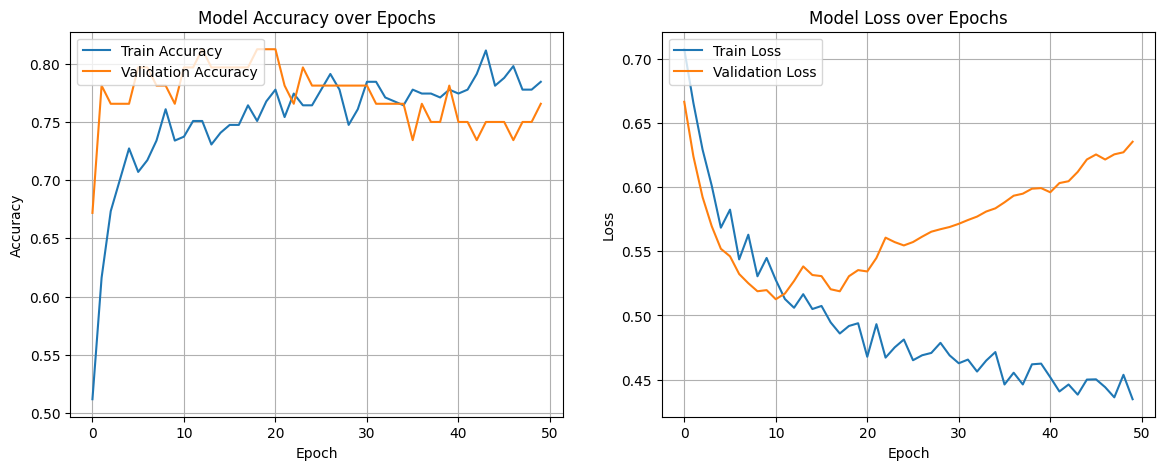

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy over Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')
ax1.grid(True)

# Plot Loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss over Epochs')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')
ax2.grid(True)
plt.show()

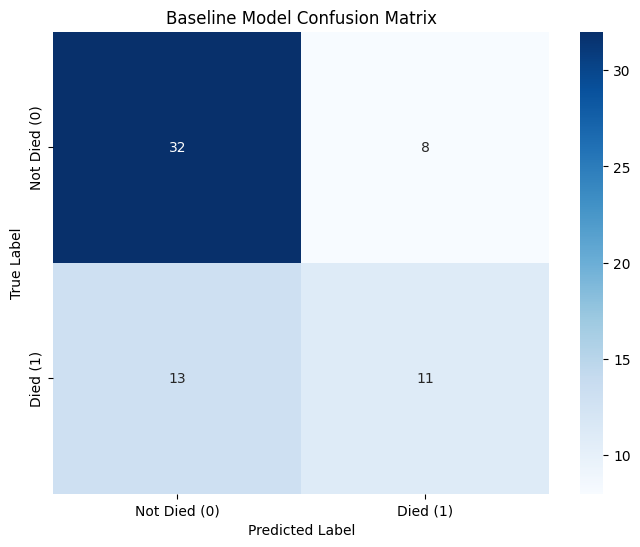

In [46]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,
            fmt='g',
            cmap='Blues',
            xticklabels=['Not Died (0)', 'Died (1)'],
            yticklabels=['Not Died (0)', 'Died (1)'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Baseline Model Confusion Matrix')
plt.show()

**So for our general observation for the first model is as follows:**

* The Model seems to overfit due to the accuracy of the Training and Test/Validation model. However, the validation accuracy seems to consistent but minimal improvement.

* The test data results seems to peform mediocre but the recall are concerning for getting the False Negative and True Positive, with it being a 50/50 chance of the model picking correct choice.


With this information we can analyze and create better model answering the following question.

# Fine Tune

Our next step is to start rework on new Neural Network Model, we will improve the model from our baseline. As we can see that the model is struggling to differentiate between died class which decrease the recall score for died class, but precision for both is mediocre but we can improve further to make it better.  

In [48]:
print(f"Original train shape: {x_train_scaled.shape}, {y_train.shape}")
smote = SMOTE(sampling_strategy='auto', random_state=SEED)
x_train_resamp, y_train_resamp = smote.fit_resample(x_train_scaled, y_train)
print(f"Resampled train shape: {x_train_resamp.shape}, {y_train_resamp.shape}")
print(f"Resampled class distribution:\n{np.mean(y_train_resamp==0)}, {np.mean(y_train_resamp==1)}")

Original train shape: (297, 20), (297,)


Resampled train shape: (368, 20), (368,)
Resampled class distribution:
0.5, 0.5


First technique we do is we resample our training set to rebalance the class weight distribution from the previous model, to now being balanced and we add more information help with the class weights.

In [49]:
l2_reg = 0.0003 # Regularization strength, for generalization

model_resamp = keras.Sequential([
    layers.InputLayer(input_shape=(input_dim,)),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)), # First Hidden Layer
    layers.BatchNormalization(), # Normalization Layer
    layers.Dropout(0.3), # Overfitting prevention
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)), # Second Hidden Layer
    layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)), # Third Hidden Layer
    layers.Dense(1, activation='sigmoid') # Output Layer
])

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Now, we initialize the model, we will add more complexity to model. First we add L2 Regularization to improve generalization, then we add Batch Normalization, here we want to make sure that our model is more consistent and speed up learning process. but we keep the layersof the model as it is.

In [50]:
tuned_optimizer = optimizers.Adam(learning_rate=0.0005)
model_resamp.compile(optimizer=tuned_optimizer, loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])
model_resamp.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,225 (16.50 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 128 (512.00 B)

This is our summary of the model, we also adjust the optimizer's learning rate to be more *thorough* and *careful* during training. We also add new metric, Precision and Recall, to inspect properly.

In [51]:
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]

This is another thing we want to implement, we want to have callbacks, to oversee the model's performance, if we see that the validation loss are starts to worsen, we also factor when the model starts to not improve and have similar learning rate, we also apply reduce learning rate to make the model even thorough and can helps the model being precise further.

In [52]:
tuned_history = model_resamp.fit(
    x_train_resamp, y_train_resamp, # New resampled data for training
    validation_data=(x_val_scaled, y_val),
    epochs=100, # Increase epochs for thorough training, model might stop earlier due to early stopping
    batch_size=32,
    callbacks=callbacks_list, # Using callbacks to prevent accuracy drop and better learning rate management
    verbose=1
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5136 - loss: 0.7551 - precision: 0.5191 - recall: 0.3696 - val_accuracy: 0.6094 - val_loss: 0.7204 - val_precision: 0.4872 - val_recall: 0.7917 - learning_rate: 5.0000e-04
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5408 - loss: 0.7205 - precision: 0.5517 - recall: 0.4348 - val_accuracy: 0.6094 - val_loss: 0.7098 - val_precision: 0.4872 - val_recall: 0.7917 - learning_rate: 5.0000e-04
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6141 - loss: 0.6873 - precision: 0.6458 - recall: 0.5054 - val_accuracy: 0.6250 - val_loss: 0.6953 - val_precision: 0.5000 - val_recall: 0.8333 - learning_rate: 5.0000e-04
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6168 - loss: 0.6717 - precision: 0.6319 - recall: 0.5598 - val_accuracy: 0.6562 - val_loss: 0.6819 - val_precision: 0.5263 - val_recall: 0.8333 - learning_rate: 5.0000e-04
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

In [53]:
results = model_resamp.evaluate(x_test_scaled, y_test, verbose=0)
loss = results[0]
accuracy = results[1]
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

Test Loss: 0.5787
Test Accuracy: 0.7188


Now, with the model accuracy have better improvement generally, we will check the model's confusion matrix and plot graph for accuracy over epoch just like last but with precision and recall metric included to see what is going on the data

In [54]:
y_pred_val = model_resamp.predict(x_test_scaled) # Probability prediction on validation set

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_val) # Calculate precision-recall curve with new data

f1_score = 2 * (precision * recall) / (precision + recall + 1e-8) # Calculate f1 score, adding small epsilon to avoid division by zero

optimal_idx = np.argmax(f1_score) # Optimal threshold over f1 score
optimal_threshold = thresholds[optimal_idx]

# Get best precision, recall, f1 at optimal threshold
best_f1 = f1_score[optimal_idx]
best_precision = precision[optimal_idx]
best_recall = recall[optimal_idx]

# print out the results
print(f'Optimal Threshold: {optimal_threshold:.4f}')
print(f'Best F1 Score at Optimal Threshold: {best_f1:.4f}')
print(f'Precision at Optimal Threshold: {best_precision:.4f}')
print(f'Recall at Optimal Threshold: {best_recall:.4f}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Optimal Threshold: 0.5821
Best F1 Score at Optimal Threshold: 0.6939
Precision at Optimal Threshold: 0.6800
Recall at Optimal Threshold: 0.7083


Now we can see that our F1 score, precision and recall are very optimal with the optimal threshold where precision and recall are balanced with the F1-Score

In [55]:
y_pred_prob_resamp = model_resamp.predict(x_test_scaled) # Get prediction probabilities using test set
y_pred_resamp = np.where(y_pred_prob_resamp >= optimal_threshold, 1, 0) # Using optimal threshold from precision-recall curve

print("Prediction Results with Resampled Model:\n", y_pred_resamp) # print out the results

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Prediction Results with Resampled Model:
 [[1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]]


In [56]:
tuned_results = model_resamp.evaluate(x_test_scaled, y_test, verbose=0)

In [57]:
tuned_loss = tuned_results[0]
tuned_accuracy = tuned_results[1]
tuned_precision = tuned_results[2]
tuned_recall = tuned_results[3]

print(f"TUNED MODEL FINAL RESULTS (Test Set):\n")
print(f"Test Accuracy (model.evaluate): {tuned_accuracy:.4f}")
print(f"Test Precision (model.evaluate): {tuned_precision:.4f}")
print(f"Test Recall (model.evaluate): {tuned_recall:.4f}")

print(classification_report(y_test, y_pred_resamp, target_names=['Not Died(0)', 'Died(1)']))

TUNED MODEL FINAL RESULTS (Test Set):

Test Accuracy (model.evaluate): 0.7188
Test Precision (model.evaluate): 0.6071
Test Recall (model.evaluate): 0.7083
              precision    recall  f1-score   support

 Not Died(0)       0.82      0.80      0.81        40
     Died(1)       0.68      0.71      0.69        24

    accuracy                           0.77        64
   macro avg       0.75      0.75      0.75        64
weighted avg       0.77      0.77      0.77        64



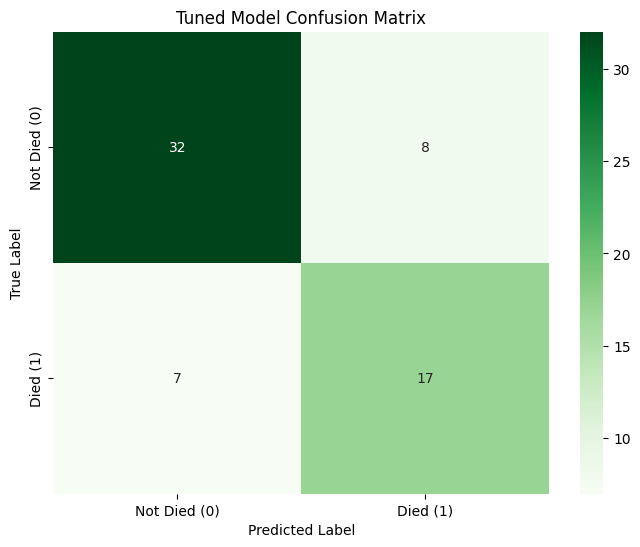

In [58]:
cm_tuned = confusion_matrix(y_test, y_pred_resamp)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned,
            annot=True,
            fmt='g',
            cmap='Greens',
            xticklabels=['Not Died (0)', 'Died (1)'],
            yticklabels=['Not Died (0)', 'Died (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Tuned Model Confusion Matrix')
plt.show()

Now, with the test data being accurate with 75% or higher accuracy, and most of data are correctly label either alive or died. We can confidently know that our model will able to generalize the information and give correct predictions to the patient with the mentioned features. 